In [17]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from scipy.spatial.distance import pdist, squareform
from matplotlib.collections import LineCollection
import time
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode
from gudhi.clustering.tomato import Tomato
import gudhi

In [18]:
np.random.seed(42)

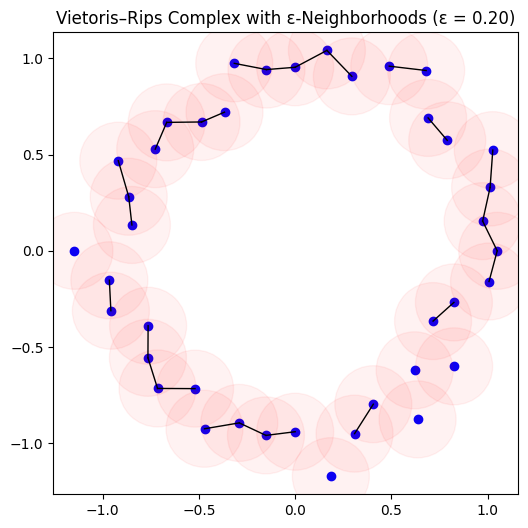

In [19]:
N = 40
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
radius = 1.0
noise = 0.1 * np.random.randn(N)
x = (radius + noise) * np.cos(angles)
y = (radius + noise) * np.sin(angles)
data = np.vstack((x, y)).T

epsilon=0.2
# def func1(epsilon=0.2):
plt.figure(figsize=(6, 6))
plt.scatter(x, y, color='blue')
D = squareform(pdist(data))

for i in range(N):
    for j in range(i + 1, N):
        if D[i, j] <= epsilon:
            plt.plot([data[i, 0], data[j, 0]], [data[i, 1], data[j, 1]], color='black', lw=1)

    circle = plt.Circle((x[i], y[i]), epsilon, color='red', fill=True, alpha=0.05, lw=1, linestyle='-')
    plt.gca().add_artist(circle)
    
plt.title(f"Vietoris–Rips Complex with ε-Neighborhoods (ε = {epsilon:.2f})")
plt.axis('equal')
plt.show()

# interact(func1, epsilon=FloatSlider(min=0.0, max=2.5, step=0.05, value=0.2))

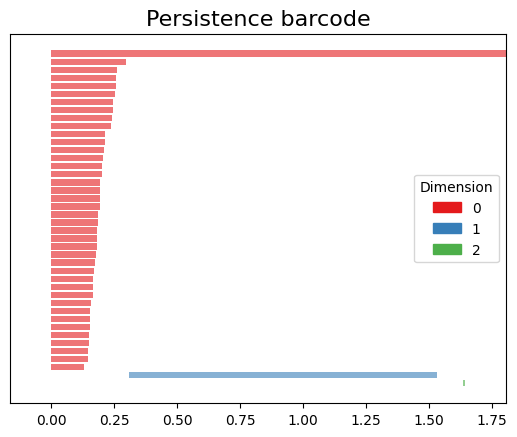

In [20]:
points = np.column_stack((x, y))

rips_complex = gudhi.RipsComplex(points=points, max_edge_length=2.5)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
diag = simplex_tree.persistence(min_persistence=0.0)

gudhi.plot_persistence_barcode(diag)
plt.show()

In [21]:
persistencefile = simplex_tree.write_persistence_diagram('persistencediag.pers')

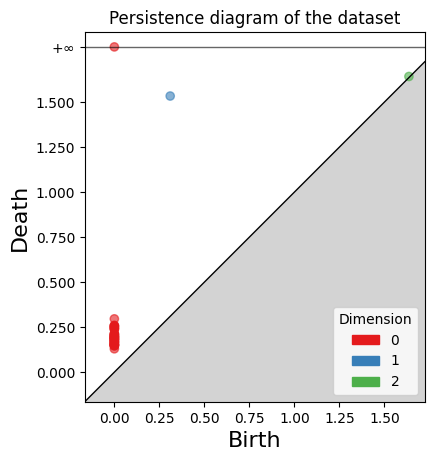

In [22]:
import matplotlib.pyplot as plt
import gudhi

persistence_file = 'persistencediag.pers'
ax = gudhi.plot_persistence_diagram(persistence_file=persistence_file)
ax.set_title("Persistence diagram of the dataset")
ax.set_aspect("equal")
plt.show()


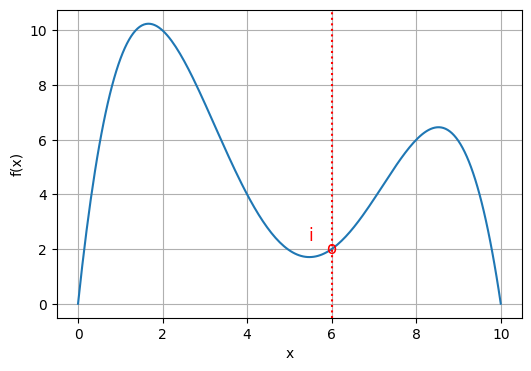

In [23]:

y = 2

xs = np.array([0, 2, 6, 8, 10])
ys = np.array([0, 10, y, 6, 0])
coeffs = np.polyfit(xs, ys, 4)
poly = np.poly1d(coeffs)

x_vals = np.linspace(0, 10, 200)
y_vals = poly(x_vals)

plt.figure(figsize=(6, 4))
plt.plot(x_vals, y_vals)

plt.text(6, y, 'o', fontsize=12, ha='center', va='center', color='red')
plt.text(5.5, y + 0.5, 'i', fontsize=12, ha='center', va='center', color='red')

plt.xlabel("x")
plt.ylabel("f(x)")
plt.axvline(x=6, color='red', linestyle=':', label='x = 6')
plt.grid(True)

plt.show()

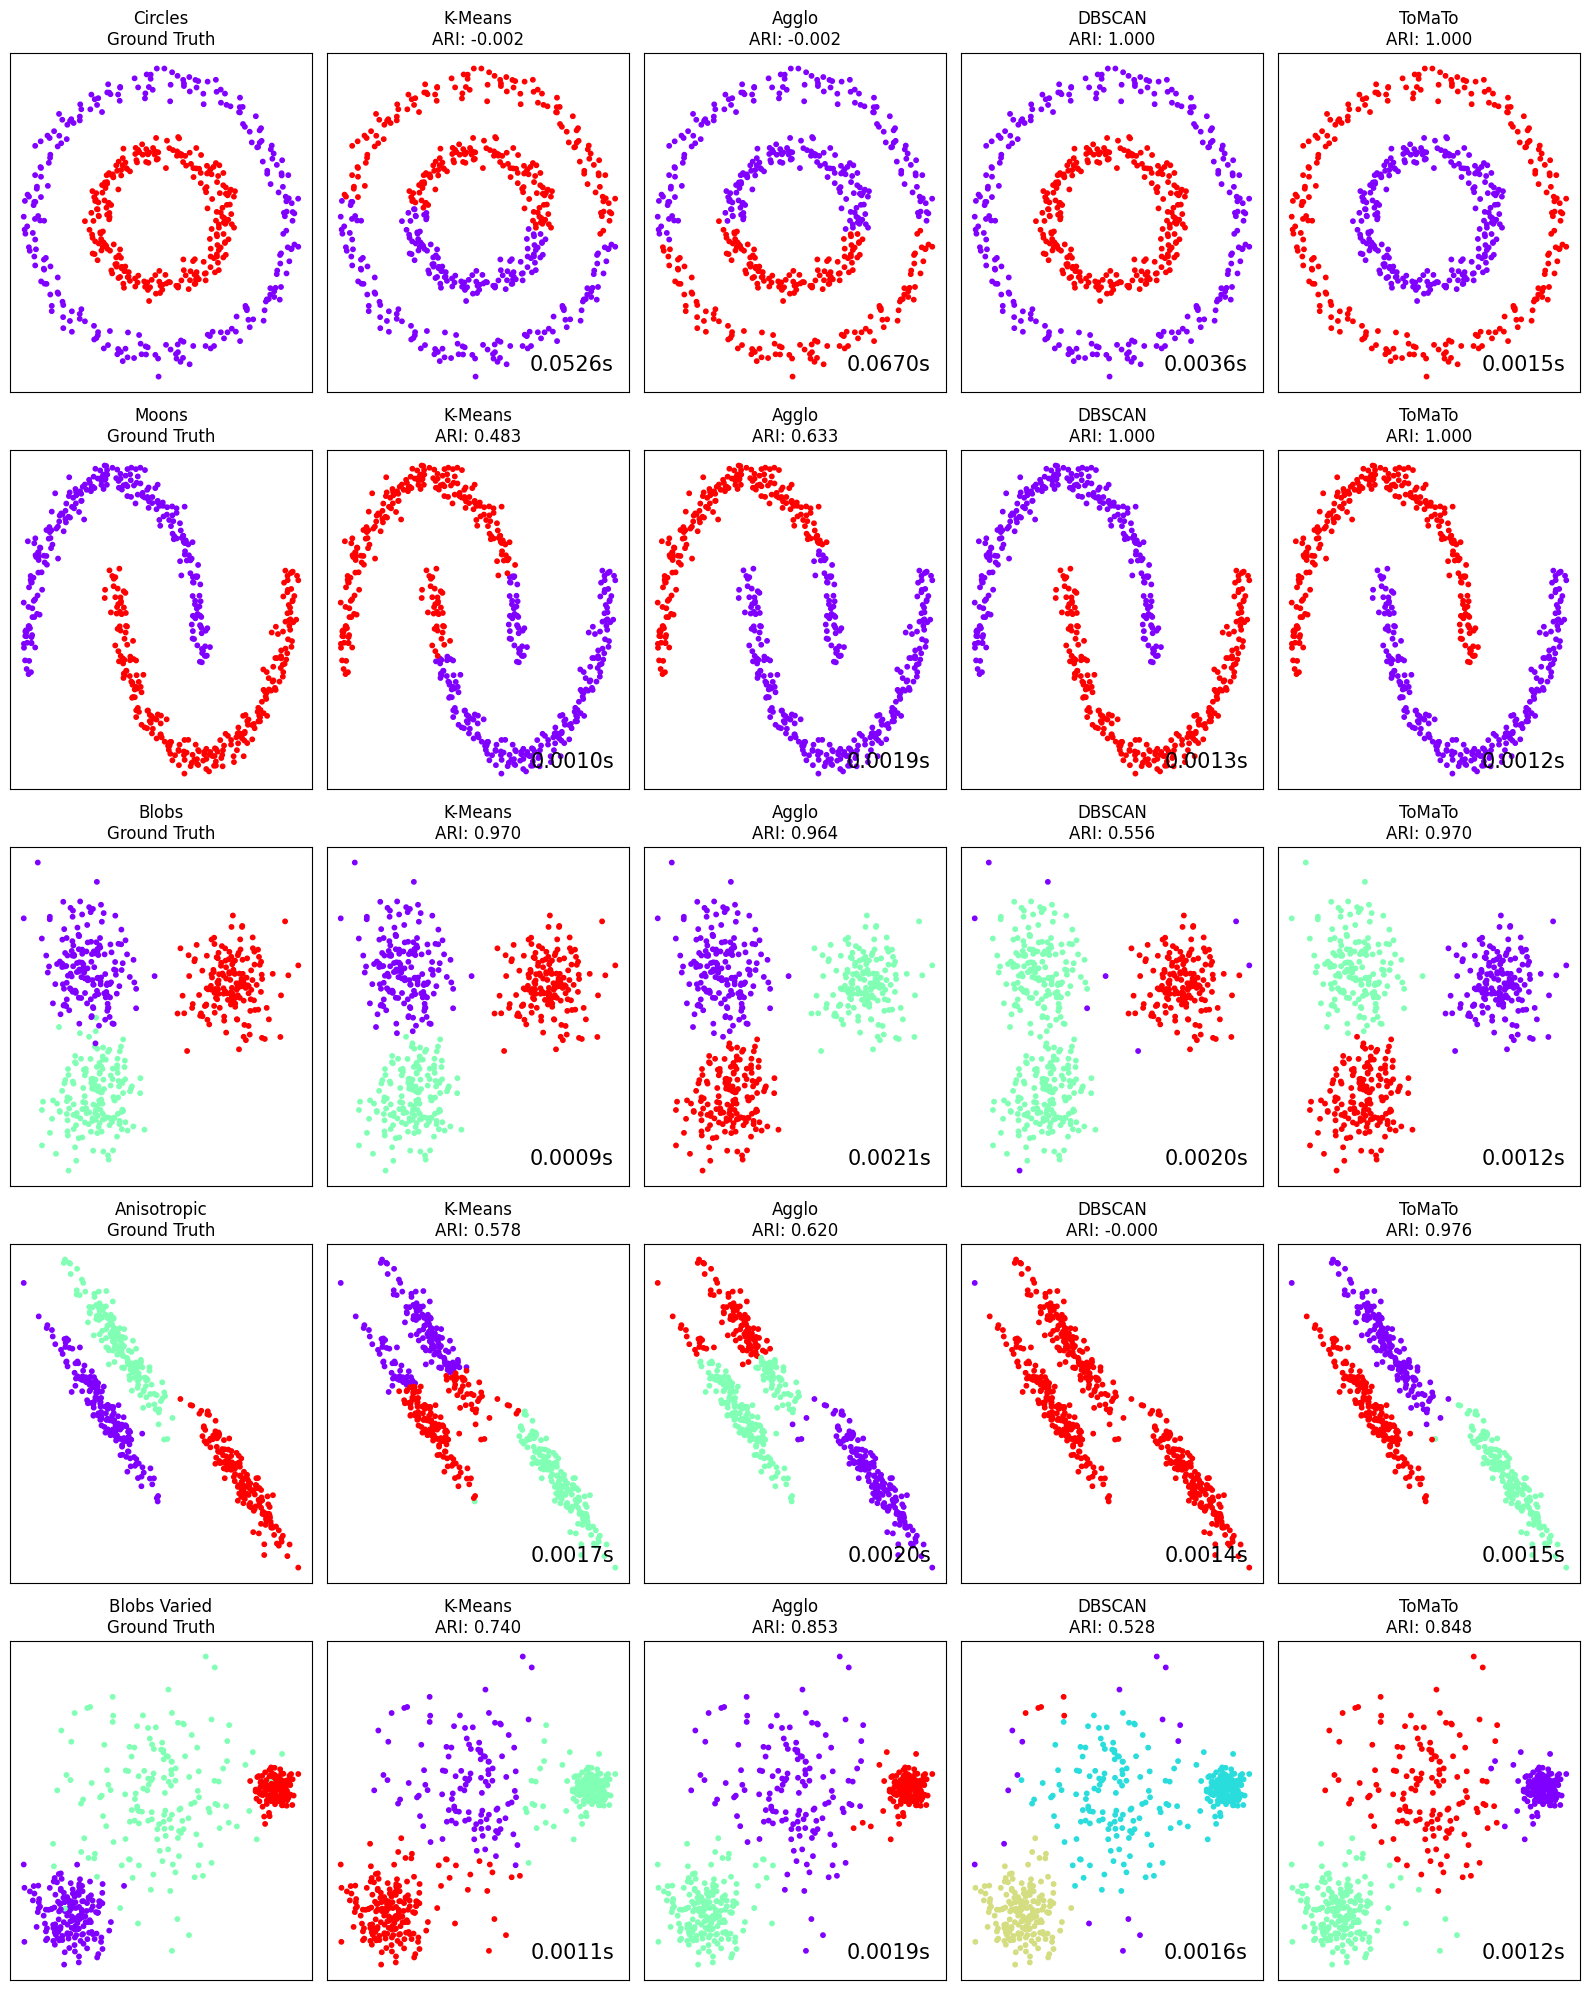

In [24]:

def adjusted_rand_accuracy(true_labels, pred_labels):
    if true_labels is None:
        return 0.0
    return adjusted_rand_score(true_labels, pred_labels)

n_samples = 500
seed = 30
random_state_aniso = 170

datasets_list = []
X_circles, y_circles = make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
datasets_list.append(("Circles", X_circles, y_circles, len(np.unique(y_circles))))

X_moons, y_moons = make_moons(
    n_samples=n_samples, noise=0.05, random_state=seed
)
datasets_list.append(("Moons", X_moons, y_moons, len(np.unique(y_moons))))

X_blobs, y_blobs = make_blobs(n_samples=n_samples, random_state=seed)
datasets_list.append(("Blobs", X_blobs, y_blobs, len(np.unique(y_blobs))))

X_aniso_base, y_aniso = make_blobs(n_samples=n_samples, random_state=random_state_aniso)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X_aniso_base, transformation)
datasets_list.append(("Anisotropic", X_aniso, y_aniso, len(np.unique(y_aniso))))

X_varied, y_varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state_aniso
)
datasets_list.append(("Blobs Varied", X_varied, y_varied, len(np.unique(y_varied))))

methods = [
    "K-Means",
    "Agglo",
    "DBSCAN",
    "ToMaTo"
]

n_methods = len(methods) + 1

plt.figure(figsize=(16, 4 * len(datasets_list)))

for ds_index, (ds_name, X, y_true, true_n_clusters) in enumerate(datasets_list):
    X_scaled = StandardScaler().fit_transform(X)
    
    ax = plt.subplot(len(datasets_list), n_methods, ds_index * n_methods + 1)
    if y_true is not None:
        ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_true, cmap='rainbow', s=10)
    else:
        ax.scatter(X_scaled[:, 0], X_scaled[:, 1], cmap='rainbow', s=10)
    ax.set_title(f"{ds_name}\nGround Truth")
    ax.set_xticks([])
    ax.set_yticks([])



    for m_index, method_name in enumerate(methods):
        ax = plt.subplot(len(datasets_list), n_methods, ds_index * n_methods + m_index + 2)
        
        
        start_time = time.time()

        n_clusters = true_n_clusters if true_n_clusters > 0 else 3
        
        if method_name == "K-Means":
            model = KMeans(n_clusters=n_clusters, random_state=42)
        elif method_name == "Agglo":
            model = AgglomerativeClustering(n_clusters=n_clusters)
        elif method_name == "ToMaTo":
            model = Tomato(n_clusters=n_clusters, k=10)
        elif method_name == "DBSCAN":
            model = DBSCAN(eps=0.3, min_samples=5)


        if method_name == "ToMaTo":
            y_pred = model.fit_predict(X_scaled)
        else:
            model.fit(X_scaled)
            y_pred = model.labels_ if hasattr(model, 'labels_') else model.predict(X_scaled)


        elapsed = time.time() - start_time

        unique_pred = len(np.unique(y_pred))
        ari = adjusted_rand_accuracy(y_true, y_pred) if (y_true is not None and unique_pred > 1) else 0.0

        ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_pred, cmap='rainbow', s=10)
        ax.set_title(f"{method_name}\nARI: {ari:.3f}")
        ax.set_xticks([])
        ax.set_yticks([])

        ax.text(0.95, 0.05,
                f"{elapsed:.4f}s",
                transform=ax.transAxes,
                ha='right', va='bottom',
                # bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
                fontsize=15)

plt.tight_layout()
plt.show()


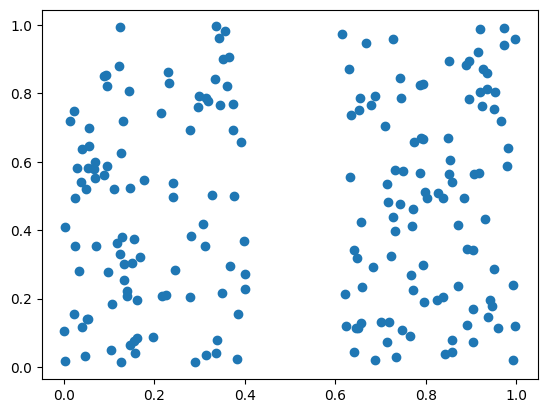

In [25]:

cmap = plt.cm.Spectral;
fig, ax = plt.subplots();

import random as rd


def x_var(x):
    if x > 0.5:
        return rd.uniform(0.6, 1)
    else:
        return rd.uniform(0, 0.4)

    
p1 = np.zeros((200,2))
for i in range(200):
    p1[i,0] = x_var(rd.uniform(0,1))
    p1[i,1] = rd.uniform(0,1)
    
ax.cla()
ax.scatter(*zip(*p1));

There are 8 initial clusters


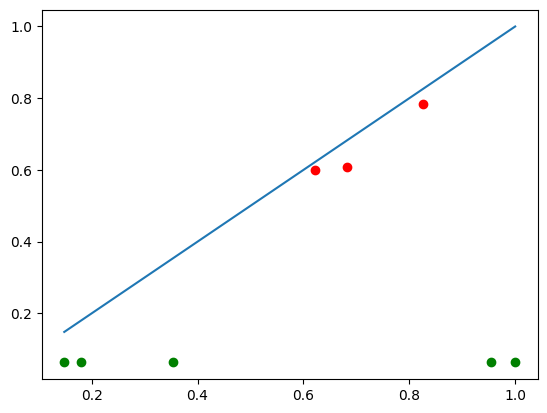

In [11]:
import gudhi

from gudhi.clustering.tomato import Tomato

ex1 = Tomato(
        input_type="points",
        metric="euclidean",
        graph_type="radius",
        density_type="KDE",
        #n_clusters=2,a
        r=0.1,
    )

ex1.fit(p1)

print("There are " + str(ex1.n_clusters_) + " initial clusters")
ex1.plot_diagram()

Initial graph over which we work upon

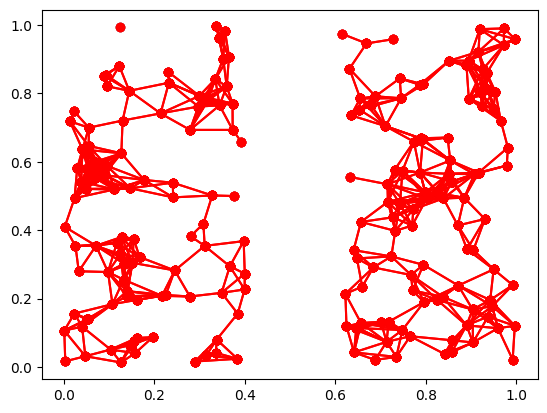

In [26]:
from sklearn.neighbors import NearestNeighbors
X = np.array(p1)
nbrs = NearestNeighbors(n_neighbors=200).fit(X)
distances, indices = nbrs.kneighbors(X)
plt.plot(X[:,0], X[:,1], 'o')
for i in indices:
    Y = np.zeros((2,2))
    for j in range(len(i)):
        if distances[i[0]][j] < 0.1:
            Y[0][0]= X[i[0]][0]
            Y[1][0]= X[i[0]][1]
            Y[0][1]= X[i[j]][0]
            Y[1][1]= X[i[j]][1]
            plt.plot(Y[0], Y[1], 'ro-')

plt.show()

We obtain 2 clusters.
[0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 1 1
 0 1 1 1 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 1
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0
 0 1 1 0 0 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 1 0
 1 0 1 0 0 0 0 1 0 1 1 0 0 1 1]

The persistance diagram looks better, with just two connected components, and two prominent regions:


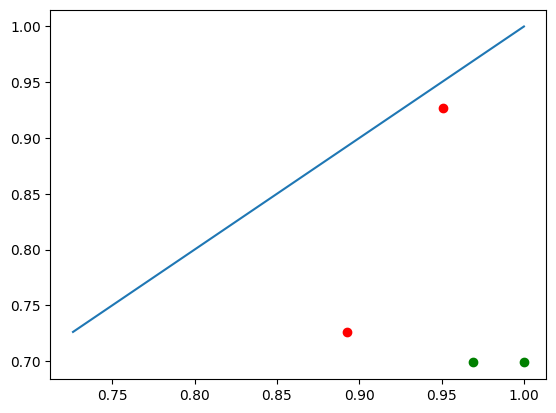


The graph over which the algorithm runs is:


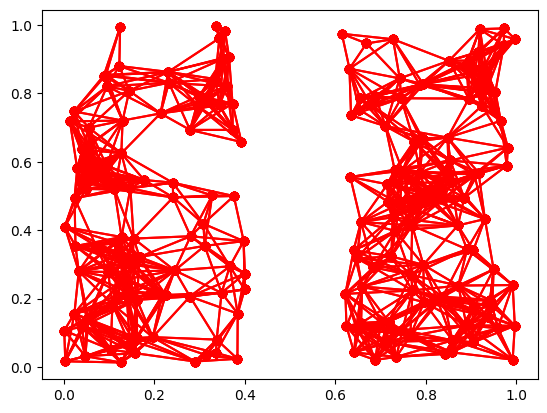


And the plot of the points according to their label is:


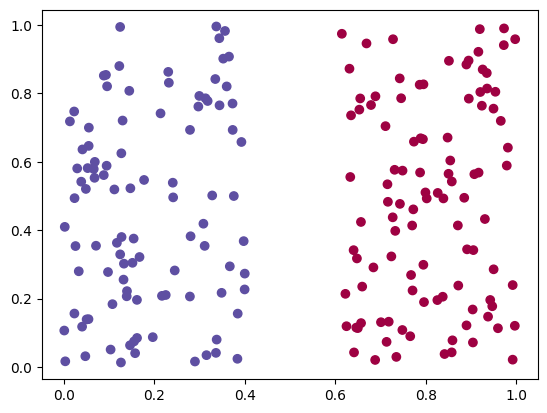

In [27]:
ex1 = Tomato(
        input_type="points",
        metric="euclidean",
        graph_type="radius",
        density_type="KDE",
        n_clusters=2,
        r=0.13,
    )

n = ex1.n_clusters_
print("We obtain " + str(n) + " clusters.")
labels = ex1.fit_predict(p1)
print(ex1.labels_)

print("\nThe persistance diagram looks better, with just two connected components, and two prominent regions:")
ex1.plot_diagram()

print("\nThe graph over which the algorithm runs is:")

plt.plot(X[:,0], X[:,1], 'o')
for i in indices:
    Y = np.zeros((2,2))
    for j in range(len(i)):
        if distances[i[0]][j] < 0.15:
            Y[0][0]= X[i[0]][0]
            Y[1][0]= X[i[0]][1]
            Y[0][1]= X[i[j]][0]
            Y[1][1]= X[i[j]][1]
            plt.plot(Y[0], Y[1], 'ro-')

plt.show()

print("\nAnd the plot of the points according to their label is:")

norm = plt.Normalize(vmin=0, vmax=n-1)

ax.cla()
ax.scatter(*zip(*p1), c=cmap(norm(labels)));
fig

# MNIST

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import TSNE
from gudhi.clustering.tomato import Tomato

In [29]:
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype(np.float64)
y = mnist.target.astype(int)

In [90]:
X.shape

(70000, 784)

In [91]:
y.shape

(70000,)

In [92]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [93]:
X.iloc[11]

pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 11, Length: 784, dtype: float64

In [94]:
X = X.to_numpy()

In [96]:
np.random.seed(42)
indices = []
for digit in range(10):
    digit_idx = np.where(y == digit)[0]
    np.random.shuffle(digit_idx)
    indices.extend(digit_idx[:1000])
indices = np.array(indices)
X_sample = X[indices]
y_sample = y[indices]
print(indices.shape)

(10000,)


In [97]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

In [98]:
print(X_sample.shape) 

(10000, 784)


In [99]:
import tensorflow as tf
from tensorflow.keras import layers, Model

inputs = tf.keras.Input(shape=(784,))
x = layers.Dense(128, activation='relu')(inputs)
encoded = layers.Dense(32, activation='relu', name='encoded')(x)
outputs = layers.Dense(10, activation='softmax')(encoded)
model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [100]:
model.fit(X_sample, y_sample, epochs=40, batch_size=32)

Epoch 1/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4248 - loss: 13.0264
Epoch 2/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5607 - loss: 1.3011
Epoch 3/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6210 - loss: 1.1576
Epoch 4/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.7013 - loss: 0.9271
Epoch 5/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.7494 - loss: 0.7917
Epoch 6/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.7763 - loss: 0.7083
Epoch 7/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.8079 - loss: 0.5953
Epoch 8/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8057 - loss: 0.5790  
Epoch 9/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8201 - loss: 0.5270
Epoch 10/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.8324 - loss: 0.4962
Epoch 11/40
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8322 - loss: 0.4504
Epoch 12/40
313/313 ━━━━━━━━━━━━━━━━━━━

In [101]:
encoder = Model(inputs=model.input, outputs=model.get_layer('encoded').output)

In [102]:
X_encoded = encoder.predict(X_sample)
X_encoded.shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step


(10000, 32)

In [103]:
tomato1 = Tomato(n_clusters=10, k=1000)
tomato_labels1 = tomato1.fit_predict(X_encoded)

The number of clusters required 10 is larger than the number of mini-clusters 2


In [104]:
tomato2 = Tomato(n_clusters=10, k=5)
tomato_labels2 = tomato2.fit_predict(X_encoded)

The number of clusters required 10 is smaller than the number of connected components 46


In [105]:
tomato3 = Tomato(n_clusters=10, k =300)
tomato_labels3 = tomato3.fit_predict(X_encoded)

In [106]:
tomato4 = Tomato(n_clusters=10, k =200)
tomato_labels4 = tomato4.fit_predict(X_encoded)

In [107]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_encoded)

In [108]:
from sklearn.metrics import adjusted_rand_score

In [109]:
adjusted_rand_score(y_sample, tomato_labels3)

0.7432402878737564

In [110]:
adjusted_rand_score(y_sample, tomato_labels4)

0.7844448239835896

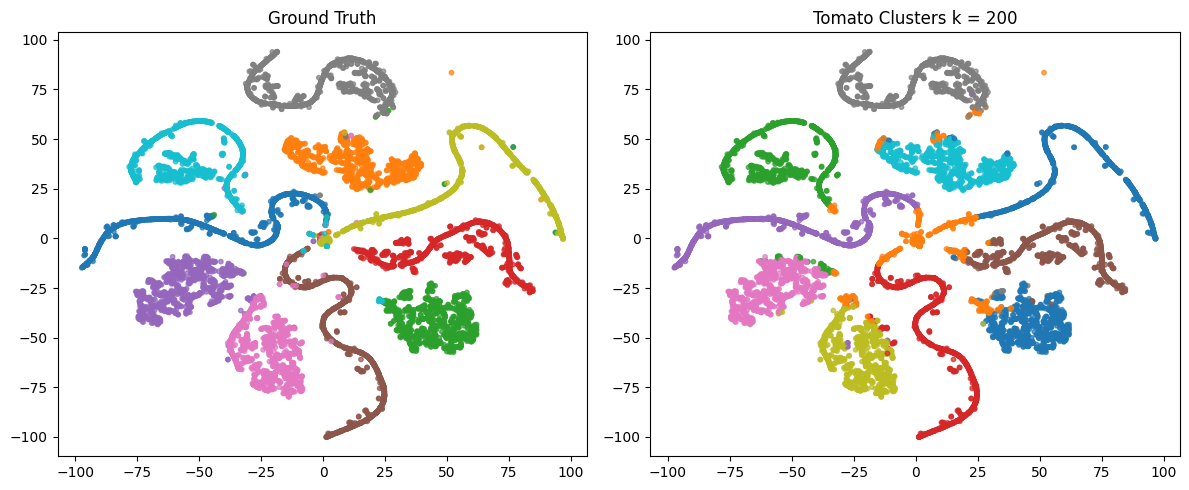

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
scatter_kwargs = dict(s=10, cmap='tab10', alpha=0.7)

axs[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, **scatter_kwargs)
axs[0].set_title("Ground Truth")


axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=tomato_labels4, **scatter_kwargs)
axs[1].set_title("Tomato Clusters k = 200")


plt.tight_layout()
plt.show()


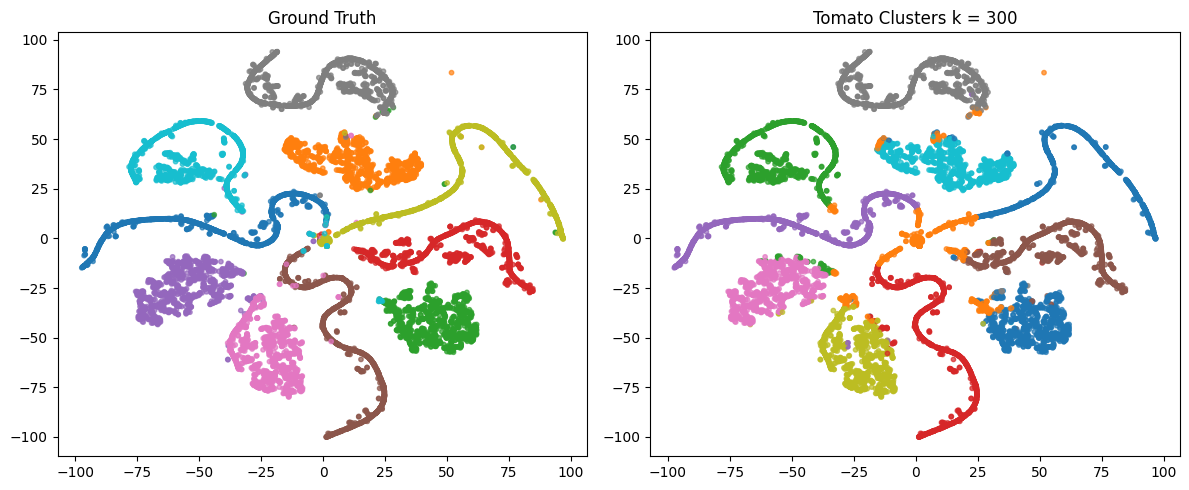

In [114]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
scatter_kwargs = dict(s=10, cmap='tab10', alpha=0.7)

axs[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, **scatter_kwargs)
axs[0].set_title("Ground Truth")


axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=tomato_labels4, **scatter_kwargs)
axs[1].set_title("Tomato Clusters k = 300")


plt.tight_layout()
plt.show()


In [115]:
km = KMeans(n_clusters=10)
kml = km.fit_predict(X_encoded)

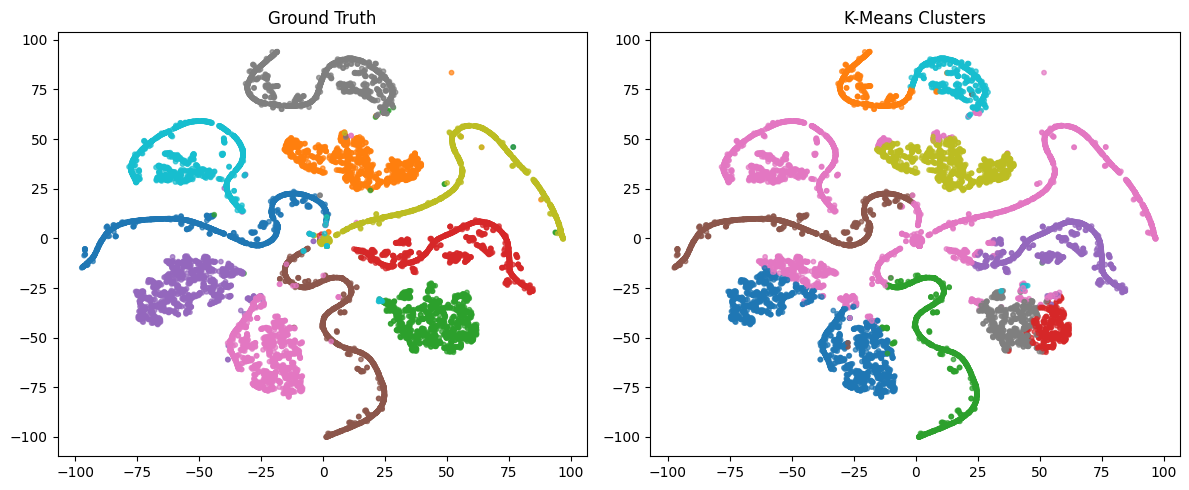

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
scatter_kwargs = dict(s=10, cmap='tab10', alpha=0.7)

axs[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, **scatter_kwargs)
axs[0].set_title("Ground Truth")


axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=kml, **scatter_kwargs)
axs[1].set_title("K-Means Clusters")


plt.tight_layout()
plt.show()


In [117]:
adjusted_rand_score(y_sample, kml)

0.5203346420138173

In [118]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import adjusted_rand_score

def clustering_metrics(true_labels, cluster_labels):

    true_labels = np.asarray(true_labels)
    cluster_labels = np.asarray(cluster_labels)
    unique_true = np.unique(true_labels)

    cont_matrix = contingency_matrix(true_labels, cluster_labels)
    cost_matrix = -cont_matrix  
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    label_mapping = dict(zip(col_ind, row_ind))
    remapped_labels = np.vectorize(label_mapping.get)(cluster_labels)

    class_accuracies = {}
    for cls in unique_true:
        mask = (true_labels == cls)
        class_total = mask.sum()
        class_correct = (remapped_labels[mask] == cls).sum()
        class_accuracies[cls] = class_correct / class_total if class_total > 0 else 0.0

    overall_accuracy = (remapped_labels == true_labels).mean()

    overall_ari = adjusted_rand_score(true_labels, cluster_labels)

    ari_per_class = {}
    for cls in unique_true:
        binary_true = (true_labels == cls).astype(int)
        ari_per_class[cls] = adjusted_rand_score(binary_true, cluster_labels)

    return {
        'class_accuracies': class_accuracies,
        'overall_accuracy': overall_accuracy,
        'ari_per_class': ari_per_class,
        'overall_ari': overall_ari
    }

In [120]:
metrics = clustering_metrics(y_sample, kml)

print("Class Accuracies:")
for cls, acc in metrics['class_accuracies'].items():
    print(f"Class {cls}: {acc:.4f}")

print(f"\nOverall Accuracy: {metrics['overall_accuracy']:.4f}")

print("\nClass ARIs:")
for cls, ari in metrics['ari_per_class'].items():
    print(f"Class {cls}: {ari:.4f}")

print(f"\nOverall ARI: {metrics['overall_ari']:.4f}")

Class Accuracies:
Class 0: 0.9160
Class 1: 0.9160
Class 2: 0.5150
Class 3: 0.8530
Class 4: 0.0000
Class 5: 0.8460
Class 6: 0.9140
Class 7: 0.5210
Class 8: 1.0000
Class 9: 0.0000

Overall Accuracy: 0.6481

Class ARIs:
Class 0: 0.0641
Class 1: 0.0646
Class 2: 0.0598
Class 3: 0.0542
Class 4: -0.0098
Class 5: 0.0524
Class 6: 0.0357
Class 7: 0.0743
Class 8: -0.0350
Class 9: -0.0350

Overall ARI: 0.5203


In [121]:
metrics = clustering_metrics(y_sample, tomato_labels4)

print("Class Accuracies:")
for cls, acc in metrics['class_accuracies'].items():
    print(f"Class {cls}: {acc:.4f}")

print(f"\nOverall Accuracy: {metrics['overall_accuracy']:.4f}")

print("\nClass ARIs:")
for cls, ari in metrics['ari_per_class'].items():
    print(f"Class {cls}: {ari:.4f}")

print(f"\nOverall ARI: {metrics['overall_ari']:.4f}")

Class Accuracies:
Class 0: 0.9450
Class 1: 0.9090
Class 2: 0.8730
Class 3: 0.8970
Class 4: 0.8820
Class 5: 0.9180
Class 6: 0.9110
Class 7: 0.9720
Class 8: 0.2020
Class 9: 0.9500

Overall Accuracy: 0.8459

Class ARIs:
Class 0: 0.0480
Class 1: 0.0460
Class 2: 0.0073
Class 3: 0.0463
Class 4: 0.0453
Class 5: 0.0459
Class 6: 0.0459
Class 7: 0.0484
Class 8: 0.0064
Class 9: 0.0456

Overall ARI: 0.7844


In [123]:
from collections import Counter

for i in range(10):
    indices = np.where(y_sample == i)

    selected_values = kml[indices]

    counts = Counter(selected_values)

    most_common_key, most_common_count = counts.most_common(1)[0]

    print(f"for {i} Most occurring key and its count:", most_common_key, most_common_count)

for 0 Most occurring key and its count: 5 916
for 1 Most occurring key and its count: 8 916
for 2 Most occurring key and its count: 7 515
for 3 Most occurring key and its count: 4 853
for 4 Most occurring key and its count: 0 615
for 5 Most occurring key and its count: 2 846
for 6 Most occurring key and its count: 0 914
for 7 Most occurring key and its count: 9 521
for 8 Most occurring key and its count: 6 1000
for 9 Most occurring key and its count: 6 1000


In [122]:
from collections import Counter

for i in range(10):
    indices = np.where(y_sample == i)

    selected_values = tomato_labels4[indices]

    counts = Counter(selected_values)

    most_common_key, most_common_count = counts.most_common(1)[0]

    print(f"for {i} Most occurring key and its count:", most_common_key, most_common_count)

for 0 Most occurring key and its count: 4 945
for 1 Most occurring key and its count: 9 909
for 2 Most occurring key and its count: 0 873
for 3 Most occurring key and its count: 5 897
for 4 Most occurring key and its count: 6 882
for 5 Most occurring key and its count: 3 918
for 6 Most occurring key and its count: 8 911
for 7 Most occurring key and its count: 7 972
for 8 Most occurring key and its count: 0 798
for 9 Most occurring key and its count: 2 950


# Palmer Penguins

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [59]:
df = pd.read_csv('/Users/harshit/Downloads/penguins_lter.csv')


In [60]:
df

studyName  Sample Number                              Species  Region  \
0     PAL0708              1  Adelie Penguin (Pygoscelis adeliae)  Anvers   
1     PAL0708              2  Adelie Penguin (Pygoscelis adeliae)  Anvers   
2     PAL0708              3  Adelie Penguin (Pygoscelis adeliae)  Anvers   
3     PAL0708              4  Adelie Penguin (Pygoscelis adeliae)  Anvers   
4     PAL0708              5  Adelie Penguin (Pygoscelis adeliae)  Anvers   
..        ...            ...                                  ...     ...   
339   PAL0910            120    Gentoo penguin (Pygoscelis papua)  Anvers   
340   PAL0910            121    Gentoo penguin (Pygoscelis papua)  Anvers   
341   PAL0910            122    Gentoo penguin (Pygoscelis papua)  Anvers   
342   PAL0910            123    Gentoo penguin (Pygoscelis papua)  Anvers   
343   PAL0910            124    Gentoo penguin (Pygoscelis papua)  Anvers   

        Island               Stage Individual ID Clutch Completion  Date Egg  \
0    Torgersen  Adult, 1 Egg Stage          N1A1               Yes  11/11/07   
1    Torgersen  Adult, 1 Egg Stage          N1A2               Yes  11/11/07   
2    Torgersen  Adult, 1 Egg Stage          N2A1               Yes  11/16/07   
3    Torgersen  Adult, 1 Egg Stage          N2A2               Yes  11/16/07   
4    Torgersen  Adult, 1 Egg Stage          N3A1               Yes  11/16/07   
..         ...                 ...           ...               ...       ...   
339     Biscoe  Adult, 1 Egg Stage         N38A2                No   12/1/09   
340     Biscoe  Adult, 1 Egg Stage         N39A1               Yes  11/22/09   
341     Biscoe  Adult, 1 Egg Stage         N39A2               Yes  11/22/09   
342     Biscoe  Adult, 1 Egg Stage         N43A1               Yes  11/22/09   
343     Biscoe  Adult, 1 Egg Stage         N43A2               Yes  11/22/09   

     Culmen Length (mm)  Culmen Depth (mm)  Flipper Length (mm)  \
0                  39.1               18.7                181.0   
1                  39.5               17.4                186.0   
2                  40.3               18.0                195.0   
3                   NaN                NaN                  NaN   
4                  36.7               19.3                193.0   
..                  ...                ...                  ...   
339                 NaN                NaN                  NaN   
340                46.8               14.3                215.0   
341                50.4               15.7                222.0   
342                45.2               14.8                212.0   
343                49.9               16.1                213.0   

     Body Mass (g)     Sex  Delta 15 N (o/oo)  Delta 13 C (o/oo)  \
0           3750.0    MALE                NaN                NaN   
1           3800.0  FEMALE            8.94956          -24.69454   
2           3250.0  FEMALE            8.36821          -25.33302   
3              NaN     NaN                NaN                NaN   
4           3450.0  FEMALE            8.76651          -25.32426   
..             ...     ...                ...                ...   
339            NaN     NaN                NaN                NaN   
340         4850.0  FEMALE            8.41151          -26.13832   
341         5750.0    MALE            8.30166          -26.04117   
342         5200.0  FEMALE            8.24246          -26.11969   
343         5400.0    MALE            8.36390          -26.15531   

                           Comments  
0    Not enough blood for isotopes.  
1                               NaN  
2                               NaN  
3                Adult not sampled.  
4                               NaN  
..                              ...  
339                             NaN  
340                             NaN  
341                             NaN  
342                             NaN  
343                             NaN  

[344 rows x 17 columns]

In [61]:
df.columns

Index(['studyName', 'Sample Number', 'Species', 'Region', 'Island', 'Stage',
       'Individual ID', 'Clutch Completion', 'Date Egg', 'Culmen Length (mm)',
       'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex',
       'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)', 'Comments'],
      dtype='object')

In [62]:
df = df.drop(columns=['studyName', 'Sample Number', 'Region', 'Island', 'Stage', 'Individual ID', 'Clutch Completion', 'Date Egg', 'Sex', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)', 'Comments'])

In [63]:
df.columns

Index(['Species', 'Culmen Length (mm)', 'Culmen Depth (mm)',
       'Flipper Length (mm)', 'Body Mass (g)'],
      dtype='object')

In [64]:
df.dropna()

Species  Culmen Length (mm)  \
0    Adelie Penguin (Pygoscelis adeliae)                39.1   
1    Adelie Penguin (Pygoscelis adeliae)                39.5   
2    Adelie Penguin (Pygoscelis adeliae)                40.3   
4    Adelie Penguin (Pygoscelis adeliae)                36.7   
5    Adelie Penguin (Pygoscelis adeliae)                39.3   
..                                   ...                 ...   
338    Gentoo penguin (Pygoscelis papua)                47.2   
340    Gentoo penguin (Pygoscelis papua)                46.8   
341    Gentoo penguin (Pygoscelis papua)                50.4   
342    Gentoo penguin (Pygoscelis papua)                45.2   
343    Gentoo penguin (Pygoscelis papua)                49.9   

     Culmen Depth (mm)  Flipper Length (mm)  Body Mass (g)  
0                 18.7                181.0         3750.0  
1                 17.4                186.0         3800.0  
2                 18.0                195.0         3250.0  
4                 19.3                193.0         3450.0  
5                 20.6                190.0         3650.0  
..                 ...                  ...            ...  
338               13.7                214.0         4925.0  
340               14.3                215.0         4850.0  
341               15.7                222.0         5750.0  
342               14.8                212.0         5200.0  
343               16.1                213.0         5400.0  

[342 rows x 5 columns]

In [65]:
df['Species'] = pd.Categorical(df['Species'])
df['Species'] = df['Species'].cat.codes

In [66]:
df

Species  Culmen Length (mm)  Culmen Depth (mm)  Flipper Length (mm)  \
0          0                39.1               18.7                181.0   
1          0                39.5               17.4                186.0   
2          0                40.3               18.0                195.0   
3          0                 NaN                NaN                  NaN   
4          0                36.7               19.3                193.0   
..       ...                 ...                ...                  ...   
339        2                 NaN                NaN                  NaN   
340        2                46.8               14.3                215.0   
341        2                50.4               15.7                222.0   
342        2                45.2               14.8                212.0   
343        2                49.9               16.1                213.0   

     Body Mass (g)  
0           3750.0  
1           3800.0  
2           3250.0  
3              NaN  
4           3450.0  
..             ...  
339            NaN  
340         4850.0  
341         5750.0  
342         5200.0  
343         5400.0  

[344 rows x 5 columns]

In [67]:
df = df.dropna(axis=0)
df

Species  Culmen Length (mm)  Culmen Depth (mm)  Flipper Length (mm)  \
0          0                39.1               18.7                181.0   
1          0                39.5               17.4                186.0   
2          0                40.3               18.0                195.0   
4          0                36.7               19.3                193.0   
5          0                39.3               20.6                190.0   
..       ...                 ...                ...                  ...   
338        2                47.2               13.7                214.0   
340        2                46.8               14.3                215.0   
341        2                50.4               15.7                222.0   
342        2                45.2               14.8                212.0   
343        2                49.9               16.1                213.0   

     Body Mass (g)  
0           3750.0  
1           3800.0  
2           3250.0  
4           3450.0  
5           3650.0  
..             ...  
338         4925.0  
340         4850.0  
341         5750.0  
342         5200.0  
343         5400.0  

[342 rows x 5 columns]

In [68]:
features = df.drop(columns=['Species'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [69]:
df

Species  Culmen Length (mm)  Culmen Depth (mm)  Flipper Length (mm)  \
0          0                39.1               18.7                181.0   
1          0                39.5               17.4                186.0   
2          0                40.3               18.0                195.0   
4          0                36.7               19.3                193.0   
5          0                39.3               20.6                190.0   
..       ...                 ...                ...                  ...   
338        2                47.2               13.7                214.0   
340        2                46.8               14.3                215.0   
341        2                50.4               15.7                222.0   
342        2                45.2               14.8                212.0   
343        2                49.9               16.1                213.0   

     Body Mass (g)  
0           3750.0  
1           3800.0  
2           3250.0  
4           3450.0  
5           3650.0  
..             ...  
338         4925.0  
340         4850.0  
341         5750.0  
342         5200.0  
343         5400.0  

[342 rows x 5 columns]

In [70]:
np.unique(df['Species'])

array([0, 1, 2], dtype=int8)

In [71]:
df.columns

Index(['Species', 'Culmen Length (mm)', 'Culmen Depth (mm)',
       'Flipper Length (mm)', 'Body Mass (g)'],
      dtype='object')

In [72]:
scaled_features.shape

(342, 4)

In [73]:
scaled_features1 = scaled_features[:, [0, 1]]  # bill_length_mm and bill_depth_mm
scaled_features2 = scaled_features[:, [0, 2]]  # flipper_length_mm and body_mass_g
scaled_features3 = scaled_features[:, [0, 3]]  # flipper_length_mm and body_mass_g

In [74]:
scaled_features3.shape

(342, 2)

In [75]:
tomato1 = Tomato(n_clusters=3)
df['label1T'] = tomato1.fit_predict(scaled_features1)

In [76]:
tomato2 = Tomato(n_clusters=3)
df['label2T'] = tomato2.fit_predict(scaled_features2)

In [77]:
tomato3 = Tomato(n_clusters=3)
df['label3T'] = tomato3.fit_predict(scaled_features3)

In [78]:
ari1T = adjusted_rand_score(df['Species'], df['label1T'])
ari2T = adjusted_rand_score(df['Species'], df['label2T'])
ari3T = adjusted_rand_score(df['Species'], df['label3T'])

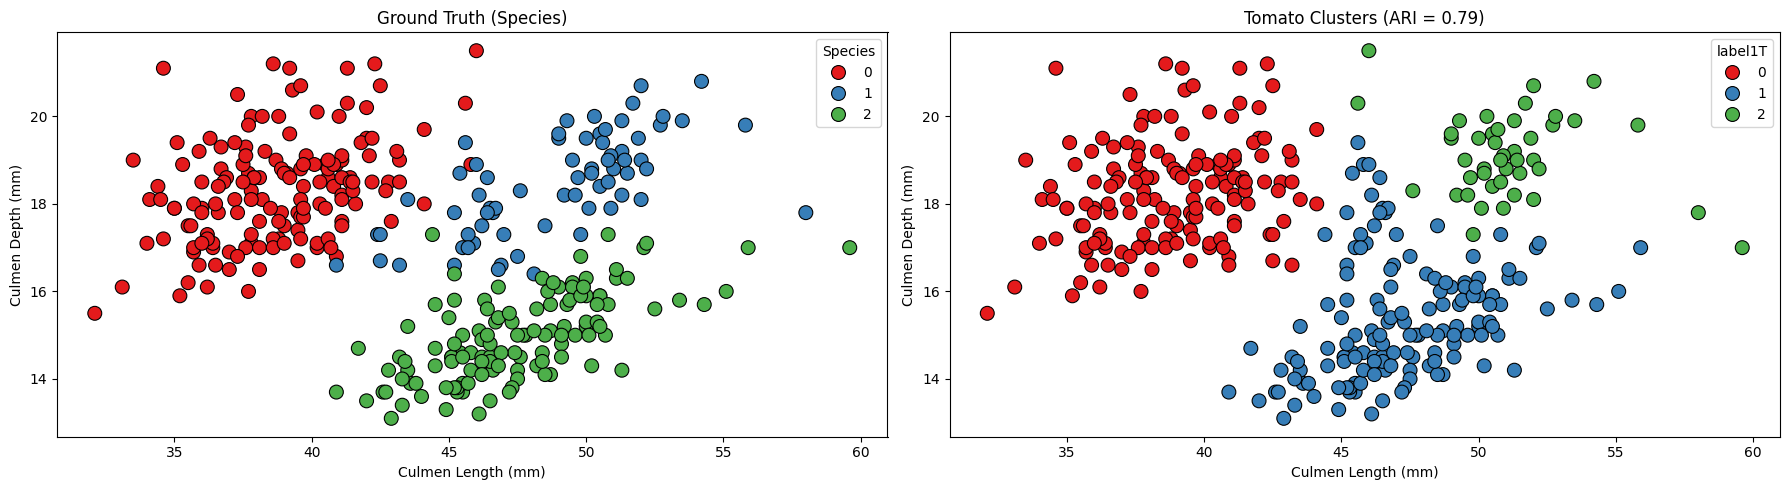

In [79]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Culmen Length (mm)', y='Culmen Depth (mm)', hue='Species', 
                data=df, palette='Set1', s=100, edgecolor='black')
plt.title('Ground Truth (Species)')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Culmen Length (mm)', y='Culmen Depth (mm)', hue='label1T', 
                data=df, palette='Set1', s=100, edgecolor='black')
plt.title(f'Tomato Clusters (ARI = {ari1T:.2f})')

plt.tight_layout()
plt.show()

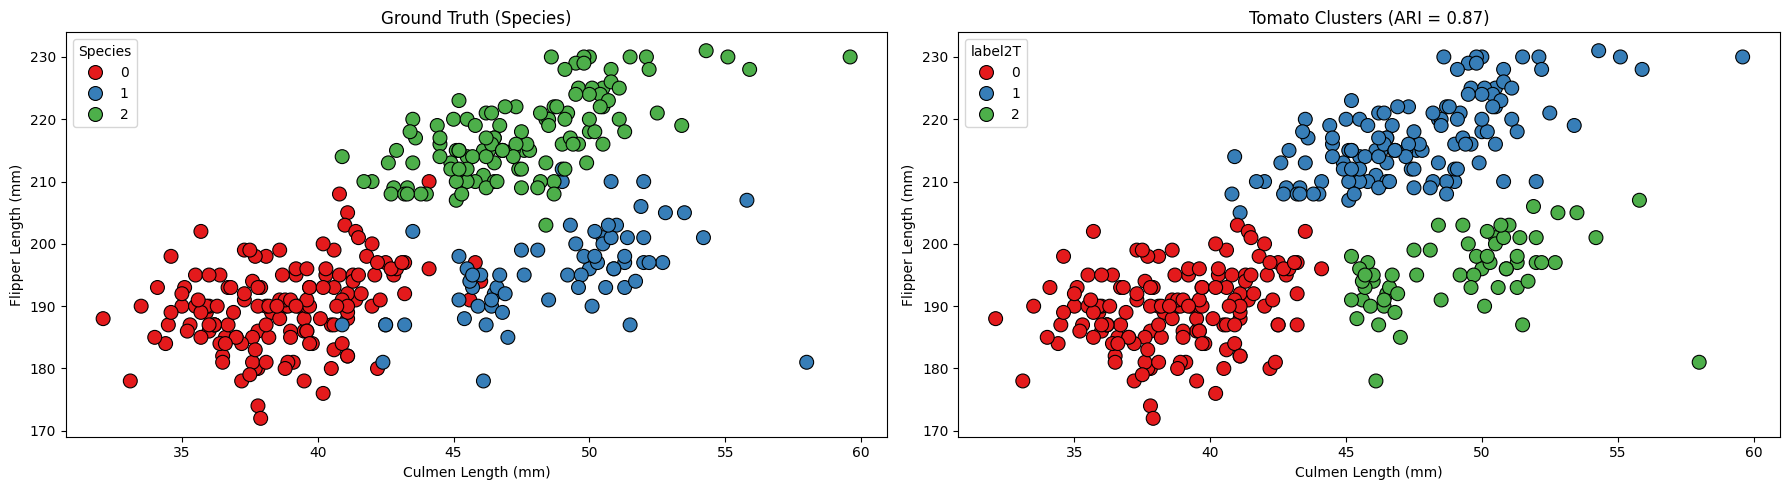

In [80]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Culmen Length (mm)', y='Flipper Length (mm)', hue='Species', 
                data=df, palette='Set1', s=100, edgecolor='black')
plt.title('Ground Truth (Species)')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Culmen Length (mm)', y='Flipper Length (mm)', hue='label2T', 
                data=df, palette='Set1', s=100, edgecolor='black')
plt.title(f'Tomato Clusters (ARI = {ari2T:.2f})')


plt.tight_layout()
plt.show()

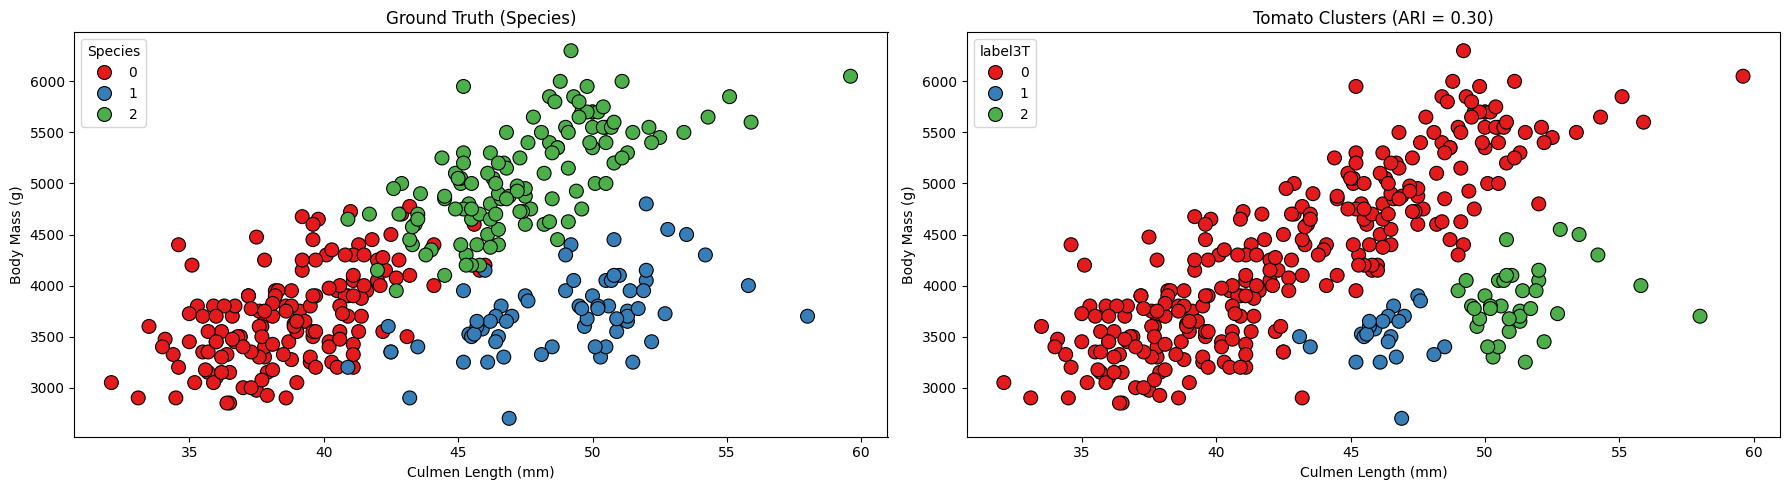

In [81]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Culmen Length (mm)', y='Body Mass (g)', hue='Species', 
                data=df, palette='Set1', s=100, edgecolor='black')
plt.title('Ground Truth (Species)')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Culmen Length (mm)', y='Body Mass (g)', hue='label3T', 
                data=df, palette='Set1', s=100, edgecolor='black')
plt.title(f'Tomato Clusters (ARI = {ari3T:.2f})')

plt.tight_layout()
plt.show()

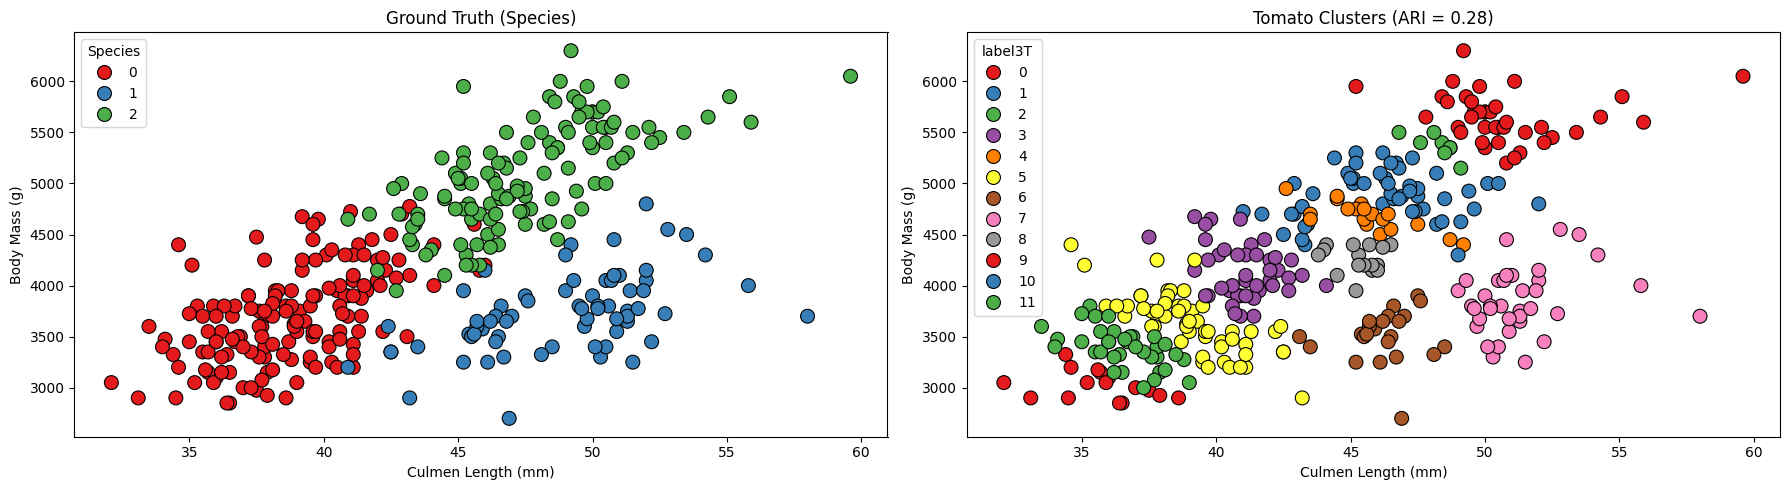

In [82]:
tomato3 = Tomato()
df['label3T'] = tomato3.fit_predict(scaled_features3)
ari3T = adjusted_rand_score(df['Species'], df['label3T'])
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Culmen Length (mm)', y='Body Mass (g)', hue='Species', 
                data=df, palette='Set1', s=100, edgecolor='black')
plt.title('Ground Truth (Species)')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Culmen Length (mm)', y='Body Mass (g)', hue='label3T', 
                data=df, palette='Set1', s=100, edgecolor='black')
plt.title(f'Tomato Clusters (ARI = {ari3T:.2f})')

plt.tight_layout()
plt.show()

In [84]:
tomato1 = Tomato()
df['label1T'] = tomato1.fit_predict(scaled_features1)
tomato2 = Tomato()
df['label2T'] = tomato2.fit_predict(scaled_features2)

In [85]:
ari1T = adjusted_rand_score(df['Species'], df['label1T'])
ari2T = adjusted_rand_score(df['Species'], df['label2T'])
ari3T = adjusted_rand_score(df['Species'], df['label3T'])

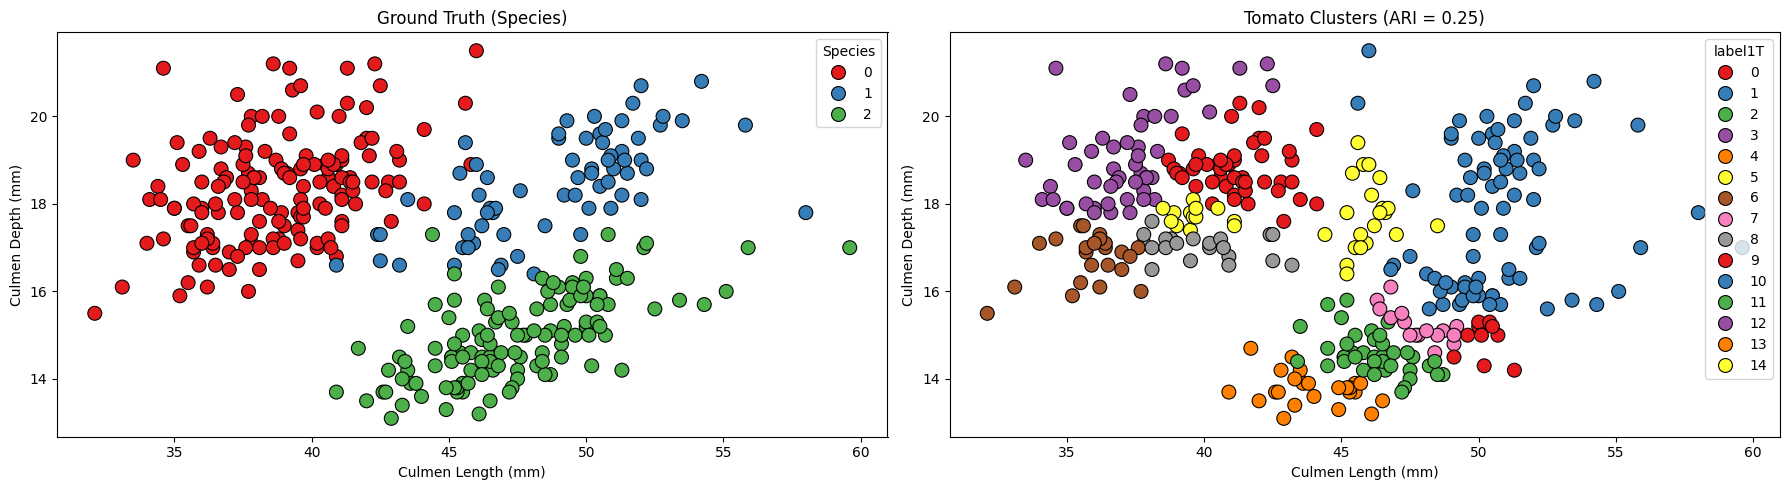

In [86]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Culmen Length (mm)', y='Culmen Depth (mm)', hue='Species', 
                data=df, palette='Set1', s=100, edgecolor='black')
plt.title('Ground Truth (Species)')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Culmen Length (mm)', y='Culmen Depth (mm)', hue='label1T', 
                data=df, palette='Set1', s=100, edgecolor='black')
plt.title(f'Tomato Clusters (ARI = {ari1T:.2f})')

plt.tight_layout()
plt.show()

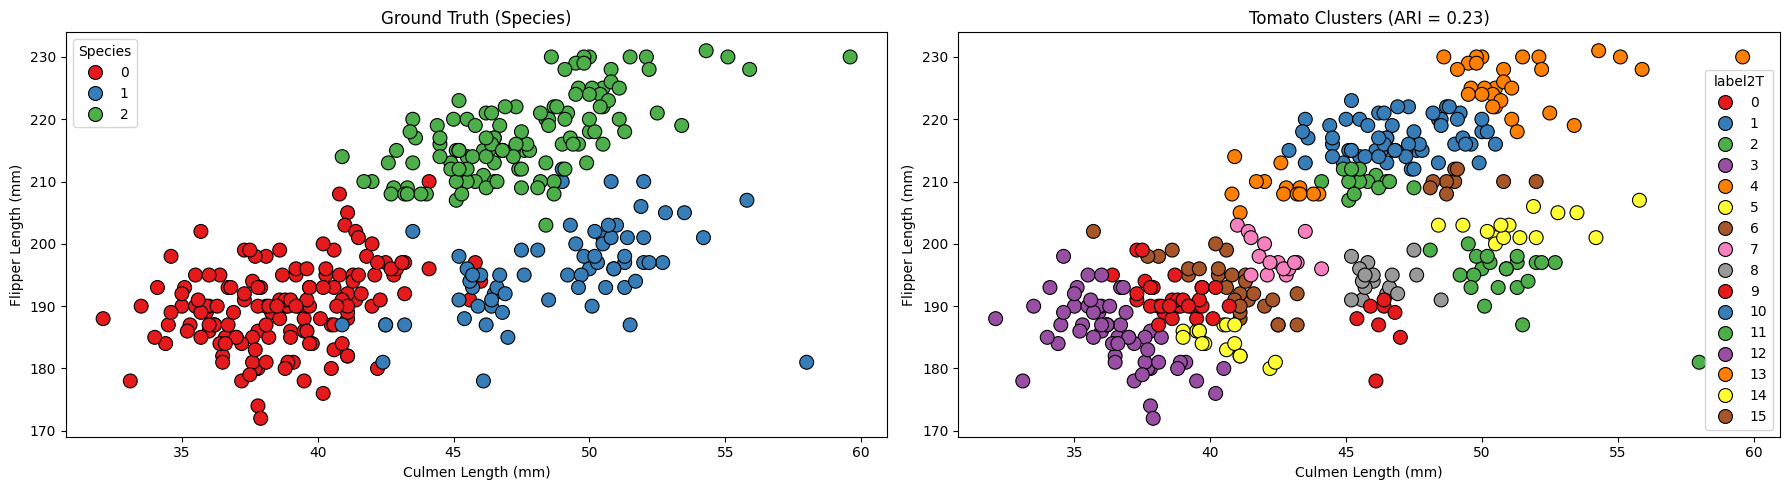

In [87]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x='Culmen Length (mm)', y='Flipper Length (mm)', hue='Species', 
                data=df, palette='Set1', s=100, edgecolor='black')
plt.title('Ground Truth (Species)')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Culmen Length (mm)', y='Flipper Length (mm)', hue='label2T', 
                data=df, palette='Set1', s=100, edgecolor='black')
plt.title(f'Tomato Clusters (ARI = {ari2T:.2f})')


plt.tight_layout()
plt.show()

In [36]:
theta1 = np.linspace (0 , 2 * np.pi , 12 , endpoint = False )
theta2 = np.linspace (0 , 2 * np.pi , 12 , endpoint = False )
scale_upper = 0.5
x1 = scale_upper * np.sin(theta1)
y1 = scale_upper * np.cos(theta1) + 1
x2 = np.sin (theta2)
y2 = np.cos (theta2) - 0.5
points = np.vstack((np.column_stack(( x1 , y1 ) ) , np.column_stack(( x2 , y2 ) ) ) )

In [37]:
points[:, 1]

array([ 1.50000000e+00,  1.43301270e+00,  1.25000000e+00,  1.00000000e+00,
        7.50000000e-01,  5.66987298e-01,  5.00000000e-01,  5.66987298e-01,
        7.50000000e-01,  1.00000000e+00,  1.25000000e+00,  1.43301270e+00,
        5.00000000e-01,  3.66025404e-01,  1.11022302e-16, -5.00000000e-01,
       -1.00000000e+00, -1.36602540e+00, -1.50000000e+00, -1.36602540e+00,
       -1.00000000e+00, -5.00000000e-01, -6.66133815e-16,  3.66025404e-01])

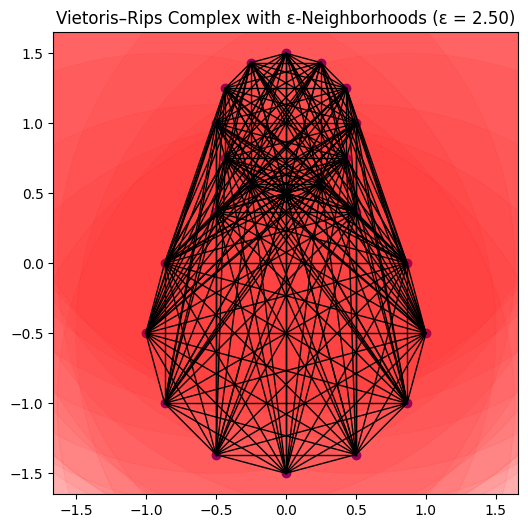

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from ipywidgets import interact, FloatSlider

theta1 = np.linspace(0, 2 * np.pi, 12, endpoint=False)
theta2 = np.linspace(0, 2 * np.pi, 12, endpoint=False)
scale_upper = 0.5
x1 = scale_upper * np.sin(theta1)
y1 = scale_upper * np.cos(theta1) + 1
x2 = np.sin(theta2)
y2 = np.cos(theta2) - 0.5
points = np.vstack((np.column_stack((x1, y1)), np.column_stack((x2, y2))))
X = points[:, 0]
y = points[:, 1]
data = points


epsilon = 2.5

plt.figure(figsize=(6, 6))
plt.scatter(X, y, color='blue')
D = squareform(pdist(data))

for i in range(len(data)):
    for j in range(i + 1, len(data)):
        if D[i, j] <= epsilon:
            plt.plot([data[i, 0], data[j, 0]], [data[i, 1], data[j, 1]], color='black', lw=1)

    circle = plt.Circle((X[i], y[i]), epsilon, color='red', fill=True, alpha=0.05, lw=1, linestyle='-')
    plt.gca().add_artist(circle)
    
plt.title(f"Vietoris–Rips Complex with ε-Neighborhoods (ε = {epsilon:.2f})")
plt.axis('equal')
plt.show()
